In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, mode, median
import seaborn as sns
from math import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import VarianceThreshold

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import tsfel

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline

#%matplotlib notebook

/home/blimen/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Samples from washing machine Beko
batch_1 = pd.read_csv("Data Processing/Beko/cleaned_data_Beko_MQTT_2024-05-04_serviettes_1.csv")
batch_2 = pd.read_csv("Data Processing/Beko/cleaned_data_Beko_MQTT_2024-05-04_serviettes_2.csv")
batch_3 = pd.read_csv("Data Processing/Beko/cleaned_data_Beko_MQTT_2024-05-04_vide_1.csv")
batch_4 = pd.read_csv("Data Processing/Beko/cleaned_data_Beko_MQTT_2024-05-04_vide_2.csv")

# Samples from washing machine Whirlpool
batch_5 = pd.read_csv("Data Processing/Whirlpool/cleaned_data_Whirlpool_MQTT_2024-05-06_serviettes_1.csv")
batch_6 = pd.read_csv("Data Processing/Whirlpool/cleaned_data_Whirlpool_MQTT_2024-05-06_serviettes_2.csv")
batch_7 = pd.read_csv("Data Processing/Whirlpool/cleaned_data_Whirlpool_MQTT_2024-05-06_vide_1.csv")
batch_8 = pd.read_csv("Data Processing/Whirlpool/cleaned_data_Whirlpool_MQTT_2024-05-06_vide_2.csv")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


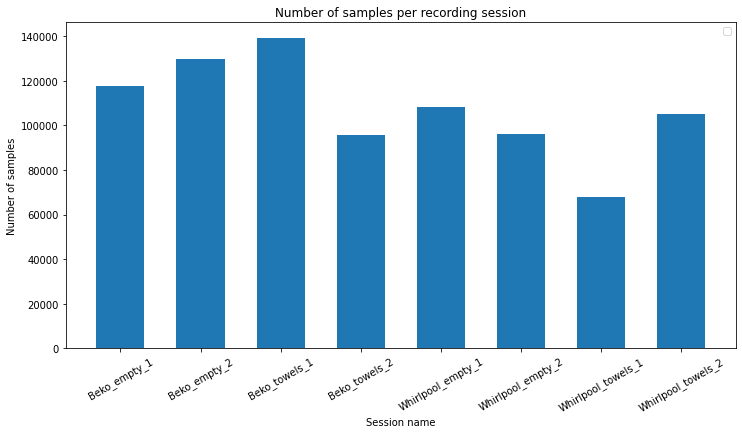

In [3]:
batch_name = ["Beko_empty_1","Beko_empty_2","Beko_towels_1","Beko_towels_2",
              "Whirlpool_empty_1","Whirlpool_empty_2","Whirlpool_towels_1","Whirlpool_towels_2"]
batch_size = [batch_1.index.stop, batch_2.index.stop, batch_3.index.stop, batch_4.index.stop,
             batch_5.index.stop, batch_6.index.stop, batch_7.index.stop, batch_8.index.stop]

plt.figure(figsize=(12, 6))
plt.bar(batch_name, batch_size, width = 0.6)
plt.xticks(rotation=30, horizontalalignment="center")
plt.title('Number of samples per recording session')
plt.xlabel('Session name')
plt.ylabel('Number of samples')
plt.legend()
plt.savefig('Size_recordings.png')
plt.show()

# Feature extraction

In [4]:
def feature_extraction(batch, cfg_file, window_size, washing_name):
    
    # remove irrelevant features
    batch = batch.drop(['index','washing_machine'], axis=1)
    
    # find frequency
    Ts = batch['timestamp'].iloc[-1]/batch.index.stop
    fs = floor(1 / Ts * 1000)
    
    # extract feature df
    batch_extracted = tsfel.time_series_features_extractor(cfg_file, batch, fs=fs, window_size=window_size)
    
    return batch_extracted, len(batch_extracted) 

def create_dataframe(cfg, window_size):
    
    batch1, y1 = feature_extraction(batch_1, cfg, window_size=window_size, washing_name = batch_1.washing_machine[0])
    batch2, y2 = feature_extraction(batch_2, cfg, window_size=window_size, washing_name = batch_2.washing_machine[0])
    batch3, y3 = feature_extraction(batch_3, cfg, window_size=window_size, washing_name = batch_3.washing_machine[0])
    batch5, y5 = feature_extraction(batch_5, cfg, window_size=window_size, washing_name = batch_5.washing_machine[0])
    batch6, y6 = feature_extraction(batch_6, cfg, window_size=window_size, washing_name = batch_6.washing_machine[0])
    batch8, y8 = feature_extraction(batch_8, cfg, window_size=window_size, washing_name = batch_8.washing_machine[0])
    
    # label encoding (convert labels in numerical values 0-> Beko and 1-> Whirlpool)
    zeros_array = np.zeros(y1+y2+y3, dtype=int)
    ones_array = np.ones(y5+y6+y8, dtype=int)
        
    df_train = pd.concat([batch1, batch2, batch3, batch5, batch6, batch8], ignore_index=True)
    y_train = np.hstack((zeros_array, ones_array))
    
    return df_train, y_train

def create_dataframe_validation(cfg, window_size, washing_name):
    
    if washing_name == 0:
        df_validation, y = feature_extraction(batch_4, cfg, window_size=window_size, washing_name = batch_4.washing_machine[0])
        y_train = np.zeros(y, dtype=int)
    else:
        df_validation, y = feature_extraction(batch_7, cfg, window_size=window_size, washing_name = batch_7.washing_machine[0])
        y_train = np.ones(y, dtype=int)
        
    return df_validation, y_train

In [44]:
cfg = tsfel.get_features_by_domain()               # All features will be extracted.
#cfg = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
#cfg = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
#cfg = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

window_size = 100     # at a sampling rate of 100 Hz, it represents 1 sec of recording

In [45]:
df_train, y = create_dataframe(cfg, window_size)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [46]:
#len(df_train)
df_train

,ADXL345_accel_x_Absolute energy,ADXL345_accel_x_Area under the curve,ADXL345_accel_x_Autocorrelation,ADXL345_accel_x_Average power,ADXL345_accel_x_Centroid,ADXL345_accel_x_ECDF Percentile Count_0,ADXL345_accel_x_ECDF Percentile Count_1,ADXL345_accel_x_ECDF Percentile_0,ADXL345_accel_x_ECDF Percentile_1,ADXL345_accel_x_ECDF_0,...,timestamp_Wavelet variance_0,timestamp_Wavelet variance_1,timestamp_Wavelet variance_2,timestamp_Wavelet variance_3,timestamp_Wavelet variance_4,timestamp_Wavelet variance_5,timestamp_Wavelet variance_6,timestamp_Wavelet variance_7,timestamp_Wavelet variance_8,timestamp_Zero crossing rate
0,37.009442,0.498284,1.0,41.495435,0.403308,20.0,80.0,-0.784532,-0.392266,0.01,...,1.365752e+05,5.063790e+05,1.098397e+06,1.885463e+06,2.846873e+06,3.954312e+06,5.142082e+06,6.288410e+06,7.274778e+06,0.0
1,38.043466,0.498637,1.0,42.654795,0.413231,20.0,80.0,-0.784532,-0.313813,0.01,...,2.215717e+05,7.626446e+05,1.601273e+06,2.681790e+06,3.949370e+06,5.349618e+06,6.828631e+06,8.332850e+06,9.808875e+06,0.0
2,36.012348,0.498991,1.0,40.377481,0.440996,20.0,80.0,-0.706079,-0.392266,0.01,...,2.845254e+05,9.788984e+05,2.053242e+06,3.434882e+06,5.056350e+06,6.849800e+06,8.745672e+06,1.067315e+07,1.256109e+07,0.0
3,46.137166,0.569316,1.0,51.729550,0.452920,20.0,80.0,-0.784532,-0.470719,0.01,...,3.549020e+05,1.221260e+06,2.562257e+06,4.289616e+06,6.316742e+06,8.556860e+06,1.092244e+07,1.332597e+07,1.568013e+07,0.0
4,41.299411,0.501464,1.0,46.305400,0.389326,20.0,80.0,-0.706079,-0.392266,0.01,...,4.331158e+05,1.490458e+06,3.126492e+06,5.232611e+06,7.703657e+06,1.043454e+07,1.331899e+07,1.625020e+07,1.912131e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,49.146914,0.672220,1.0,47.161180,0.503201,20.0,80.0,-0.862985,-0.392266,0.01,...,8.861003e+09,3.047635e+10,6.392098e+10,1.069641e+11,1.574107e+11,2.130732e+11,2.717655e+11,3.313025e+11,3.894994e+11,0.0
6950,40.597752,0.612761,1.0,38.957438,0.522939,20.0,80.0,-0.784532,-0.392266,0.01,...,8.874225e+09,3.052250e+10,6.401763e+10,1.071255e+11,1.576484e+11,2.133957e+11,2.721777e+11,3.318052e+11,3.900892e+11,0.0
6951,34.295129,0.552063,1.0,32.909467,0.487224,20.0,80.0,-0.706079,-0.313813,0.01,...,8.887275e+09,3.056697e+10,6.411086e+10,1.072815e+11,1.578777e+11,2.137057e+11,2.725725e+11,3.322861e+11,3.906543e+11,0.0
6952,34.990633,0.576012,1.0,33.576870,0.518417,20.0,80.0,-0.706079,-0.392266,0.01,...,8.900466e+09,3.061239e+10,6.420739e+10,1.074448e+11,1.581183e+11,2.140300e+11,2.729844e+11,3.327861e+11,3.912400e+11,0.0


In [47]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [48]:
# split train & validation -> 80% training /20% testing
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.20, random_state = 0)

In [49]:
# Scaling & preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
# Check for dimensions
X_train.shape, y_train.shape

((5563, 1656), (5563,))

In [51]:
# Check for dimensions
X_test.shape, y_test.shape

((1391, 1656), (1391,))

In [52]:
# Define pipeline 
classifiers = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),     # "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=9)
}

metrics = {
    "Classifier": [],
    "Accuracy": [],
    "Recall": [],
    "Precision": []
}

confusion_matrices = {}

In [53]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
    
    metrics["Classifier"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Recall"].append(recall)
    metrics["Precision"].append(precision)
    
    confusion_matrices[name] = confusion_matrix(y_test, y_pred, labels=clf.classes_)


In [54]:
# print metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

      Classifier  Accuracy   Recall  Precision
0            SVM  1.000000  1.00000   1.000000
1  Decision Tree  1.000000  1.00000   1.000000
2    Naive Bayes  0.672897  0.27476   0.994220
3            KNN  0.998562  1.00000   0.996815


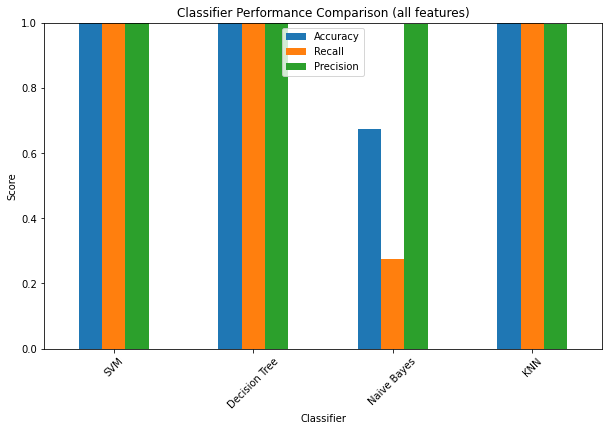

In [55]:
# Grouped bar plot for accuracy, precision, and recall
metrics_df.set_index("Classifier", inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
#plt.title("Classifier Performance Comparison (all features)")
#plt.title("Classifier Performance Comparison (statistical features)")
#plt.title("Classifier Performance Comparison (temporal features)")
#plt.title("Classifier Performance Comparison (spectral features)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
#plt.savefig('Classifier_Performance_all.png')
#plt.savefig('Classifier_Performance_statistical.png')
#plt.savefig('Classifier_Performance_temporal.png')
#plt.savefig('Classifier_Performance_spectral.png')
plt.show()


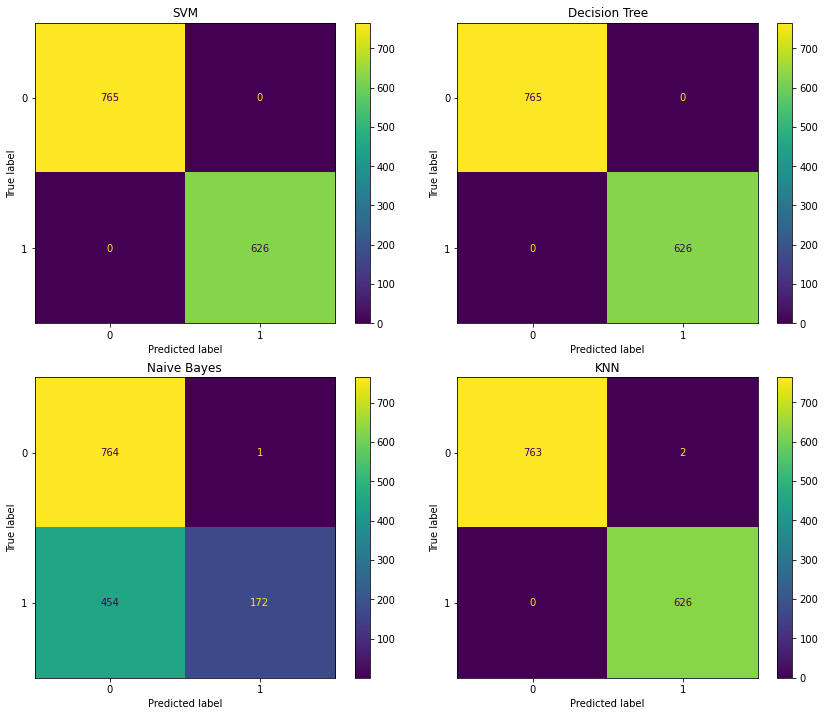

In [56]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, matrix) in zip(axes.flatten(), confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap='viridis')
    ax.title.set_text(name)

plt.tight_layout()
#plt.savefig("Confusion_matrices_all.png")
#plt.savefig("Confusion_matrices_statistical.png")
#plt.savefig("Confusion_matrices_temporal.png")
#plt.savefig("Confusion_matrices_spectral.png")
plt.show()

# Test on new dataset from Whirlpool
Note: Label associated to this washing machine is '1'

In [73]:
df_val, y_val = create_dataframe_validation(cfg, window_size, 1)

*** Feature extraction started ***



*** Feature extraction finished ***


In [74]:
# Scaling & preprocessing
scaler = StandardScaler()
X_val = scaler.fit_transform(df_val)

In [75]:
validation_metrics = {
    "Classifier": [],
    "Accuracy": [],
    "Recall": []
}

validation_confusion_matrices = {}

In [76]:
for name, clf in classifiers.items():
    y_val_pred = clf.predict(X_val)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='binary')
    val_recall = recall_score(y_val, y_val_pred, average='binary')
    
    validation_metrics["Classifier"].append(name)
    validation_metrics["Accuracy"].append(val_accuracy)
    validation_metrics["Recall"].append(val_recall)
    
    validation_confusion_matrices[name] = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)


In [77]:
validation_metrics_df = pd.DataFrame(validation_metrics)
print(validation_metrics_df)

      Classifier  Accuracy    Recall
0            SVM  0.398818  0.398818
1  Decision Tree  0.503693  0.503693
2    Naive Bayes  0.610044  0.610044
3            KNN  0.838996  0.838996


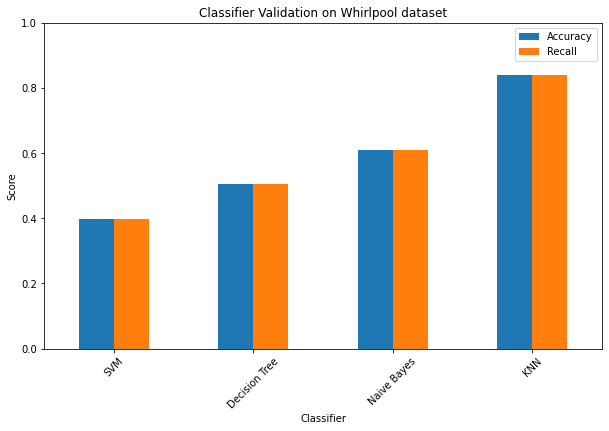

In [78]:
# Grouped bar plot for validation accuracy, precision, and recall
validation_metrics_df.set_index("Classifier", inplace=True)
validation_metrics_plot = validation_metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Classifier Validation on Whirlpool dataset")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.savefig('Classifier_Performance_Whirlpool.png')
plt.show()

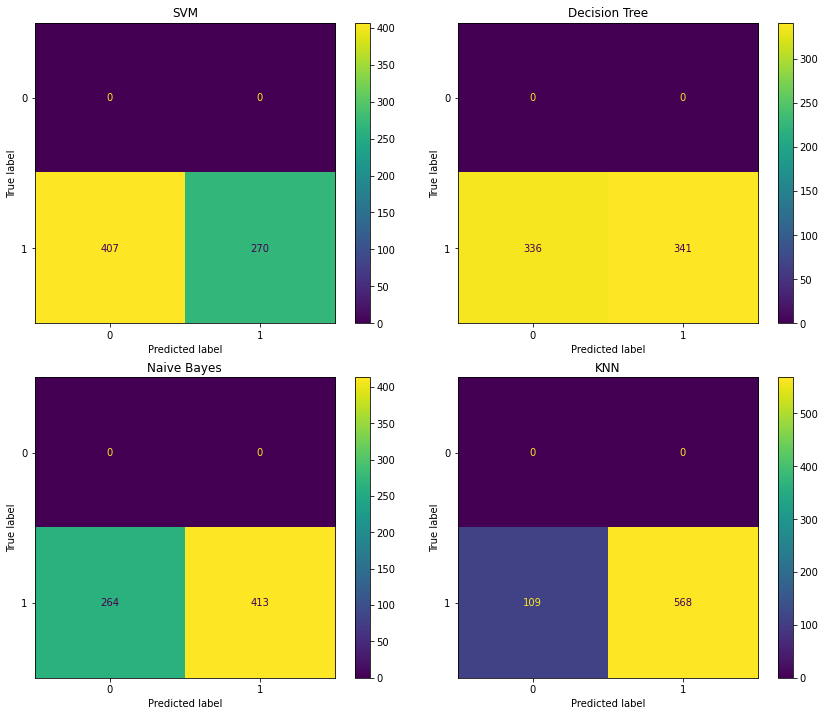

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, matrix) in zip(axes.flatten(), validation_confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap='viridis')
    ax.title.set_text(name)
    
plt.tight_layout()
plt.savefig("Confusion_matrices_validation_W.png")
plt.show()

# Test on new dataset from Beko
Note: Label associated to this washing machine is '0'

In [80]:
df_val, y_val = create_dataframe_validation(cfg, window_size, 0)

*** Feature extraction started ***



*** Feature extraction finished ***


In [81]:
# Scaling & preprocessing
scaler = StandardScaler()
X_val = scaler.fit_transform(df_val)

In [82]:
validation_metrics = {
    "Classifier": [],
    "Accuracy": [],
    "Specificity": []
}

validation_confusion_matrices = {}

In [83]:
for name, clf in classifiers.items():
    y_val_pred = clf.predict(X_val)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_specificity = specificity_score(y_val, y_val_pred, average='binary')
    
    validation_metrics["Classifier"].append(name)
    validation_metrics["Accuracy"].append(val_accuracy)
    validation_metrics["Specificity"].append(val_specificity)
    
    validation_confusion_matrices[name] = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)


In [84]:
validation_metrics_df = pd.DataFrame(validation_metrics)
print(validation_metrics_df)

      Classifier  Accuracy  Specificity
0            SVM  0.715183     0.715183
1  Decision Tree  0.554974     0.554974
2    Naive Bayes  0.873298     0.873298
3            KNN  0.869110     0.869110


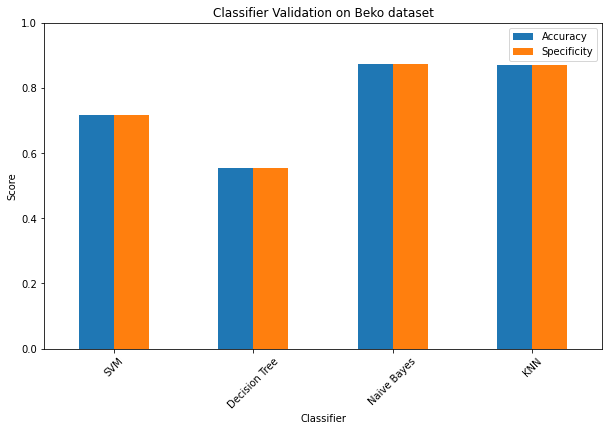

In [85]:
# Grouped bar plot for validation accuracy, precision, and recall
validation_metrics_df.set_index("Classifier", inplace=True)
validation_metrics_plot = validation_metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Classifier Validation on Beko dataset")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.savefig('Classifier_Performance_Beko.png')
plt.show()

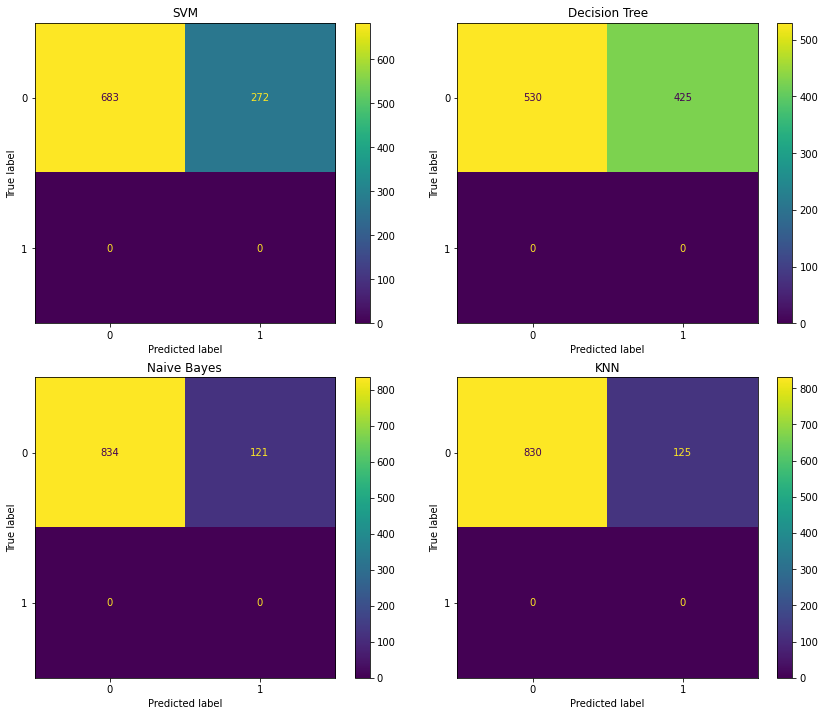

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, matrix) in zip(axes.flatten(), validation_confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap='viridis')
    ax.title.set_text(name)
    
plt.tight_layout()
plt.savefig("Confusion_matrices_validation_B.png")
plt.show()

# Sources
Tsfel:
- https://github.com/fraunhoferportugal/tsfel/blob/master/notebooks/TSFEL_SMARTWATCH_HAR_Example.ipynb
- https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html

Confusion matrix:
- https://accessibleai.dev/post/interpreting_confusion_matrixes/

